In [1]:
import pandas as pd
import os
from datetime import datetime, timezone
import datetime as dt
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Read Data

In [2]:
os.chdir("C:/Users/Θανάσης/Desktop/Efood")

In [3]:
data = pd.read_csv('Assessment exercise dataset - orders.csv')

In [4]:
data.head() 

,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount
0,7322173742136,94223136441,2022-01-18 15:41:28 UTC,Αίγιο,Breakfast,True,3.6
1,7210978616924,204794985423,2022-01-02 17:50:50 UTC,Αγρίνιο,Breakfast,True,1.9
2,7221232906132,12703920390,2022-01-04 08:37:12 UTC,Αγρίνιο,Breakfast,True,1.7
3,7399605199800,673310109528,2022-01-31 11:33:05 UTC,Λιβαδειά,Breakfast,True,3.0
4,7264221279744,673310109528,2022-01-10 11:18:28 UTC,Λιβαδειά,Breakfast,True,3.0


# Data Preprocessing

### Fix the type of timestamp variable

In [5]:
data.dtypes

order_id             int64
user_id              int64
order_timestamp     object
city                object
cuisine             object
paid_cash             bool
amount             float64
dtype: object

In [6]:
data['order_timestamp'] = pd.to_datetime(data['order_timestamp'])

In [7]:
data['order_timestamp'] = data['order_timestamp'].dt.tz_localize(None) 

##### Add day names

In [8]:
my_date = data['order_timestamp']
day = pd.to_datetime(my_date).dt.day_name()
data['day'] = day
data.head()

,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount,day
0,7322173742136,94223136441,2022-01-18 15:41:28,Αίγιο,Breakfast,True,3.6,Tuesday
1,7210978616924,204794985423,2022-01-02 17:50:50,Αγρίνιο,Breakfast,True,1.9,Sunday
2,7221232906132,12703920390,2022-01-04 08:37:12,Αγρίνιο,Breakfast,True,1.7,Tuesday
3,7399605199800,673310109528,2022-01-31 11:33:05,Λιβαδειά,Breakfast,True,3.0,Monday
4,7264221279744,673310109528,2022-01-10 11:18:28,Λιβαδειά,Breakfast,True,3.0,Monday


In [9]:
data.dtypes

order_id                    int64
user_id                     int64
order_timestamp    datetime64[ns]
city                       object
cuisine                    object
paid_cash                    bool
amount                    float64
day                        object
dtype: object

### Check unique values of key columns

In [10]:
data.user_id.nunique()

121943

In [11]:
data.city.nunique()

46

In [12]:
data.order_id.nunique()

534270

In [13]:
def unique_counts(data):
   for i in data.columns:
       count = data[i].nunique()
       print(i, ": ", count)
unique_counts(data)

order_id :  534270
user_id :  121943
order_timestamp :  457853
city :  46
cuisine :  4
paid_cash :  2
amount :  2061
day :  7


### Drop Duplicates if needed

In [14]:
city_user_order=data[['city','user_id','order_id']].drop_duplicates()


### Check top cities and users per order

In [16]:
city_user_order.groupby(['user_id'])['order_id'].aggregate('count').reset_index().sort_values('order_id', ascending=False).head()

,user_id,order_id
32224,154559060124,135
21549,104460666828,107
24847,119884693362,105
5968,32214575190,100
54302,247344644274,88


In [17]:
city_user_order.groupby(['city',])['order_id','user_id'].aggregate('nunique').reset_index().sort_values('order_id', ascending=False).head()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,city,order_id,user_id
27,Λάρισα,84943,22088
15,Βόλος,77529,17499
26,Ιωάννινα,67972,16861
43,Ρόδος,50730,11155
40,Ξάνθη,49401,9227


### Check for Null values

In [18]:
data.isnull().sum(axis=0)

order_id           0
user_id            0
order_timestamp    0
city               0
cuisine            0
paid_cash          0
amount             0
day                0
dtype: int64

# RFM Customer Segmentation

In [19]:
data['order_timestamp'].max()

Timestamp('2022-01-31 23:59:53')

In [21]:
next_date = dt.datetime(2022,2,1)
next_date

datetime.datetime(2022, 2, 1, 0, 0)

### Create a RFM table

In [22]:
rfmTable = data.groupby('user_id').agg({'order_timestamp': lambda x: (next_date - x.max()).days, 'order_id': lambda x: len(x), 'amount': lambda x: x.sum()})
rfmTable['order_timestamp'] = rfmTable['order_timestamp'].astype(int)
rfmTable.rename(columns={'order_timestamp': 'recency', 
                         'order_id': 'frequency', 
                         'amount': 'monetary_value'}, inplace=True)

In [23]:
rfmTable.head()

,recency,frequency,monetary_value
user_id,,,
44118921,26,1,33.3
108938802,4,3,44.2
110361993,7,11,137.0
138437670,3,1,5.5
144777339,0,14,60.8


### Let’s check the details of the customer with the highest monetary value

In [24]:
rfmTable.sort_values(by=['monetary_value'], ascending=False).head()

,recency,frequency,monetary_value
user_id,,,
485537911656,0,38,1351.50
154559060124,0,135,945.40
629495492640,0,24,863.05
119884693362,0,105,839.95
589547556318,0,52,796.00


In [25]:
customer1 = data[data['user_id'] == 485537911656]
customer1

,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount,day
211386,7357172664748,485537911656,2022-01-23 13:41:23,Ρόδος,Italian,False,37.0,Sunday
211391,7394452826884,485537911656,2022-01-30 16:23:56,Ρόδος,Italian,False,40.0,Sunday
229648,7308190003420,485537911656,2022-01-16 15:35:49,Ρόδος,Italian,False,49.0,Sunday
229652,7243436617364,485537911656,2022-01-07 13:40:51,Ρόδος,Italian,False,37.0,Friday
229654,7364157236540,485537911656,2022-01-24 17:20:44,Ρόδος,Italian,False,30.0,Monday
229660,7300487123904,485537911656,2022-01-15 15:37:52,Ρόδος,Italian,False,39.5,Saturday
236357,7370888359932,485537911656,2022-01-26 19:14:35,Ρόδος,Italian,False,25.0,Wednesday
236358,7252427568260,485537911656,2022-01-08 18:23:29,Ρόδος,Italian,False,30.0,Saturday
247823,7349689848360,485537911656,2022-01-22 13:31:39,Ρόδος,Italian,False,48.0,Saturday
256932,7211833349804,485537911656,2022-01-02 19:46:40,Ρόδος,Italian,False,32.0,Sunday


In [26]:
customer1["amount"].mean()

35.565789473684205

### Split the metrics

In [27]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [28]:
segmented_rfm = rfmTable

### The lowest recency, highest frequency and monetary amounts are our best customers.

In [29]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

### Add segment numbers to the newly created segmented RFM table

In [30]:
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
user_id,,,,,,
44118921,26,1,33.3,4,4,2
108938802,4,3,44.2,2,2,2
110361993,7,11,137.0,2,1,1
138437670,3,1,5.5,2,4,4
144777339,0,14,60.8,1,1,1


### Add a new column to combine RFM score: 111 is the highest score as we determined earlier.

In [31]:
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)

segmented_rfm.sort_values(by=['RFMScore','monetary_value'], ascending=True).head(10)


,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
user_id,,,,,,,
158803145067,0,6,47.3,1,1,1,111
185633012418,0,11,47.3,1,1,1,111
273034018110,1,6,47.3,1,1,1,111
305841546423,0,6,47.3,1,1,1,111
564728528469,2,7,47.3,1,1,1,111
602450723448,1,7,47.3,1,1,1,111
645128728251,1,9,47.3,1,1,1,111
664868775564,1,6,47.3,1,1,1,111
669220505499,2,10,47.3,1,1,1,111


In [32]:
Top_Customers = segmented_rfm[segmented_rfm['RFMScore']=='111']
Top_Customers.RFMScore.count()

15597

# Plot

In [33]:
rfmTable2 = rfmTable.reset_index()
rfmTable2 = rfmTable2[['RFMScore']]
rfmTable2.head()

,RFMScore
0,442
1,222
2,211
3,244
4,111


In [34]:
grouped_by_rfmscore = rfmTable2.groupby(['RFMScore']).size().reset_index(name = 'count').sort_values('count', ascending=False)
grouped_by_rfmscore.head()

,RFMScore,count
0,111,15597
63,444,12467
47,344,6806
62,443,6587
5,122,5376


In [35]:
data_plot = [go.Bar(x=grouped_by_rfmscore['RFMScore'], y=grouped_by_rfmscore['count'])]

layout = go.Layout(
    title=go.layout.Title(
        text='Customer RFM Segments'
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text='RFM Segment'
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text='Number of Customers'
        )
    )
)

fig = go.Figure(data=data_plot, layout=layout)
iplot(fig, filename='rfm_Segments')

In [36]:
segmented_rfm.describe()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
count,121943.000000,121943.000000,121943.000000,121943.000000,121943.000000,121943.000000
mean,9.762036,4.381309,37.339123,2.424567,2.608301,2.502718
std,9.154451,5.443188,41.786941,1.164638,1.175263,1.119542
min,0.000000,1.000000,0.400000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,11.600000,1.000000,2.000000,2.000000
50%,7.000000,2.000000,23.300000,2.000000,3.000000,3.000000
75%,16.000000,5.000000,47.300000,3.000000,4.000000,4.000000
max,30.000000,135.000000,1351.500000,4.000000,4.000000,4.000000


# Create Matrix

In [37]:
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
user_id,,,,,,,
44118921,26,1,33.3,4,4,2,442
108938802,4,3,44.2,2,2,2,222
110361993,7,11,137.0,2,1,1,211
138437670,3,1,5.5,2,4,4,244
144777339,0,14,60.8,1,1,1,111


In [38]:
BestCustomers = ['111']
BigSpenders = ['331','121','221','321','131','231','341','241','141']
LoyalCustomers = ['212','112','211','312','313','113','213','114','214','314']
Promising = ['222','223','123','122']
Worrying = ['311']
LostBestCustomers = ['411']
LostCustomers = ['422','412','421','432','442','431','441']
LostCheapCustomers = ['433','444','434','424','413','423','443','414']

In [39]:

def f(row):

    if row['RFMScore'] in BestCustomers:
        val = 'Best Customers'
    elif row['RFMScore'] in BigSpenders:
        val = 'Big Spenders'
    elif row['RFMScore'] in LoyalCustomers:
        val = 'Loyal Customers'
    elif row['RFMScore'] in Promising:
        val = 'Promising'
    elif row['RFMScore'] in Worrying:
        val = 'Worrying'        
    elif row['RFMScore'] in LostBestCustomers:
        val = 'Lost Best Customers'   
    elif row['RFMScore'] in LostCustomers:
        val = 'Lost Customers'
    elif row['RFMScore'] in LostCheapCustomers:
        val = 'Lost Cheap Customers'
    else:
        val = 'Need Attention'
    return val

In [40]:
segmented_rfm['segment'] = segmented_rfm.apply(f, axis=1)

In [41]:
segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,segment
user_id,,,,,,,,
44118921,26,1,33.3,4,4,2,442,Lost Customers
108938802,4,3,44.2,2,2,2,222,Promising
110361993,7,11,137.0,2,1,1,211,Loyal Customers
138437670,3,1,5.5,2,4,4,244,Need Attention
144777339,0,14,60.8,1,1,1,111,Best Customers


In [42]:
grouped_by_segment = segmented_rfm.groupby(['segment']).size().reset_index(name = 'count').sort_values('count', ascending=False)
grouped_by_segment

,segment,count
6,Need Attention,42083
3,Lost Cheap Customers,24385
0,Best Customers,15597
7,Promising,14293
5,Loyal Customers,10947
1,Big Spenders,6946
4,Lost Customers,5659
8,Worrying,1699
2,Lost Best Customers,334


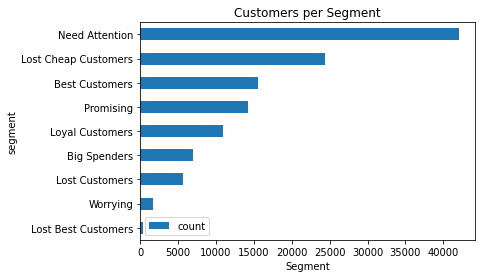

In [43]:
ax = grouped_by_segment.plot.barh(x='segment',y='count', align='center')
ax.invert_yaxis()
ax.set_xlabel('Segment')
ax.set_title('Customers per Segment')
plt.show()


### Per City

In [44]:
segmented_rfm.head().reset_index()

,user_id,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,segment
0,44118921,26,1,33.3,4,4,2,442,Lost Customers
1,108938802,4,3,44.2,2,2,2,222,Promising
2,110361993,7,11,137.0,2,1,1,211,Loyal Customers
3,138437670,3,1,5.5,2,4,4,244,Need Attention
4,144777339,0,14,60.8,1,1,1,111,Best Customers


In [45]:
data_new = data.merge(segmented_rfm, how="left",on = 'user_id')

In [46]:
data_new.head()

,order_id,user_id,order_timestamp,city,cuisine,paid_cash,amount,day,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,segment
0,7322173742136,94223136441,2022-01-18 15:41:28,Αίγιο,Breakfast,True,3.6,Tuesday,2,11,103.6,1,1,1,111,Best Customers
1,7210978616924,204794985423,2022-01-02 17:50:50,Αγρίνιο,Breakfast,True,1.9,Sunday,4,7,30.5,2,1,2,212,Loyal Customers
2,7221232906132,12703920390,2022-01-04 08:37:12,Αγρίνιο,Breakfast,True,1.7,Tuesday,0,21,35.7,1,1,2,112,Loyal Customers
3,7399605199800,673310109528,2022-01-31 11:33:05,Λιβαδειά,Breakfast,True,3.0,Monday,0,8,23.9,1,1,2,112,Loyal Customers
4,7264221279744,673310109528,2022-01-10 11:18:28,Λιβαδειά,Breakfast,True,3.0,Monday,0,8,23.9,1,1,2,112,Loyal Customers


In [47]:
grouped_by_city = data_new.groupby(['city','segment']).agg({'RFMScore': lambda x: x.count()})
grouped_by_city.head()

RFMScore
city   segment                       
Άνδρος Need Attention               8
Άργος  Best Customers             897
       Big Spenders               214
       Lost Best Customers         44
       Lost Cheap Customers       223

# Breakfast

In [49]:
data_new3 = data_new.drop(['order_id'], axis=1)

In [50]:
data_new2 = data_new3.drop_duplicates('user_id')

In [51]:
grouped_by_cuisine = data_new.groupby(['cuisine','segment']).agg({'user_id': lambda x: x.nunique()}).sort_values('user_id', ascending=False)
grouped_by_cuisine = grouped_by_cuisine.reset_index()
grouped_by_cuisine

,cuisine,segment,user_id
0,Meat,Need Attention,21681
1,Meat,Best Customers,13778
2,Breakfast,Need Attention,13241
3,Italian,Need Attention,13197
4,Breakfast,Best Customers,12650
5,Italian,Best Customers,11029
6,Meat,Promising,10572
7,Meat,Lost Cheap Customers,9796
8,Breakfast,Loyal Customers,8757
9,Meat,Loyal Customers,8450


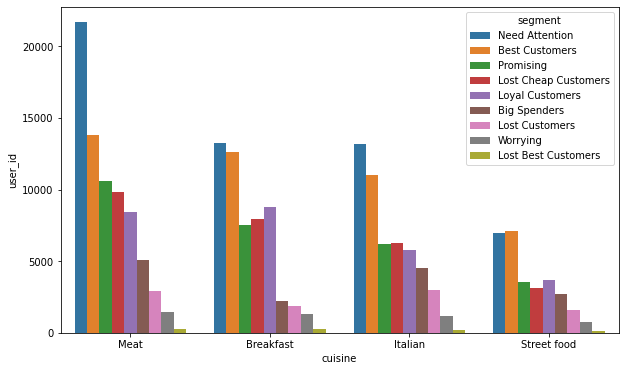

In [52]:
plt.figure(figsize=(10, 6))
sns.barplot(x="cuisine", hue="segment", y="user_id", data=grouped_by_cuisine)
plt.show()

### Create Frequency pivot

In [53]:
data_new.pivot_table(values='user_id', index='cuisine', columns='segment', aggfunc=lambda x: len(x.unique()))

segment,Best Customers,Big Spenders,Lost Best Customers,Lost Cheap Customers,Lost Customers,Loyal Customers,Need Attention,Promising,Worrying
cuisine,,,,,,,,,
Breakfast,12650,2217,297,7925,1901,8757,13241,7507,1339
Italian,11029,4529,222,6271,3021,5781,13197,6209,1146
Meat,13778,5075,258,9796,2915,8450,21681,10572,1425
Street food,7108,2710,143,3136,1598,3666,6970,3535,734


# Association Analysis

In [55]:
basket = (data_new.groupby(['user_id', 'cuisine'])['order_id']
          .nunique().unstack().reset_index().fillna(0)
          .set_index('user_id'))

In [56]:
basket.head()

cuisine,Breakfast,Italian,Meat,Street food
user_id,,,,
44118921,0.0,0.0,1.0,0.0
108938802,0.0,0.0,3.0,0.0
110361993,1.0,4.0,3.0,3.0
138437670,0.0,0.0,1.0,0.0
144777339,14.0,0.0,0.0,0.0


### Structure the data

In [57]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
basket_sets.head()

cuisine,Breakfast,Italian,Meat,Street food
user_id,,,,
44118921,0,0,1,0
108938802,0,0,1,0
110361993,1,1,1,1
138437670,0,0,1,0
144777339,1,0,0,0


In [58]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

In [59]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Italian),(Street food),0.421549,0.242736,0.106115,0.251726,1.037037,0.003790,1.012014
1,(Street food),(Italian),0.242736,0.421549,0.106115,0.437162,1.037037,0.003790,1.027739
2,"(Italian, Breakfast)",(Meat),0.179075,0.606431,0.125550,0.701104,1.156115,0.016954,1.316741
3,"(Italian, Meat)",(Breakfast),0.235561,0.457870,0.125550,0.532985,1.164054,0.017694,1.160842
4,"(Breakfast, Meat)",(Italian),0.253586,0.421549,0.125550,0.495101,1.174479,0.018652,1.145675
5,(Italian),"(Breakfast, Meat)",0.421549,0.253586,0.125550,0.297831,1.174479,0.018652,1.063012
6,(Breakfast),"(Italian, Meat)",0.457870,0.235561,0.125550,0.274206,1.164054,0.017694,1.053245
7,(Meat),"(Italian, Breakfast)",0.606431,0.179075,0.125550,0.207032,1.156115,0.016954,1.035255
8,"(Breakfast, Street food)",(Meat),0.110552,0.606431,0.075880,0.686373,1.131825,0.008838,1.254897
9,"(Breakfast, Meat)",(Street food),0.253586,0.242736,0.075880,0.299227,1.232725,0.014325,1.080612


#### Support vs Confidence

In [62]:
#plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
#plt.xlabel('support')
#plt.ylabel('confidence')
#plt.title('Support vs Confidence')
#plt.show()

#### Support vs Lift

In [ ]:
#plt.scatter(rules['support'], rules['lift'], alpha=0.5)
#plt.xlabel('support')
#plt.ylabel('lift')
#plt.title('Support vs Lift')
#plt.show()

#### Lift vs Confidence

In [ ]:
#fit = np.polyfit(rules['lift'], rules['confidence'], 1)
#fit_fn = np.poly1d(fit)
#plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
#fit_fn(rules['lift']))

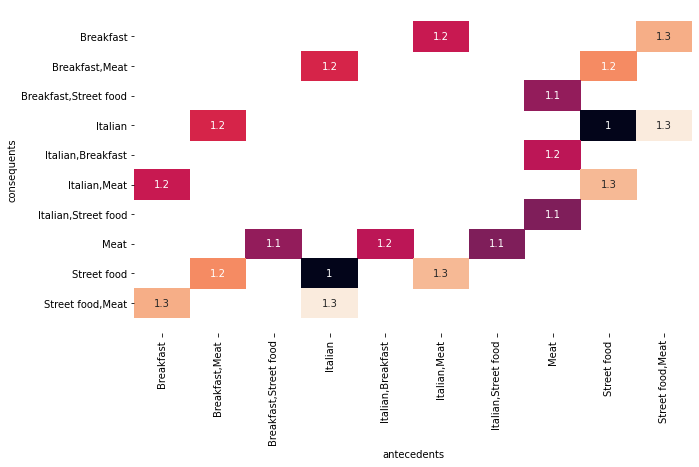

In [64]:
rules['antecedents'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform antecedent, consequent, and support columns into matrix
support_table = rules.pivot(index='consequents', columns='antecedents', values='lift')

plt.figure(figsize=(10,6))
sns.heatmap(support_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show() 

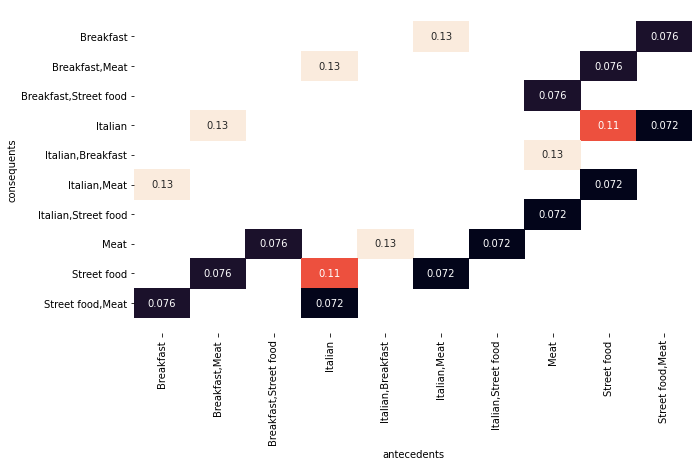

In [65]:
# Transform antecedent, consequent, and support columns into matrix
support_table = rules.pivot(index='consequents', columns='antecedents', values='support')

plt.figure(figsize=(10,6))
sns.heatmap(support_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show() 